In [1]:
import os
print(os.getcwd())
def update_working_directory():
    from pathlib import Path
    p = Path(os.getcwd()).parents[0]
    os.chdir(p)
    print(p)
update_working_directory()

/Users/admin/Projects/doggo/notebooks
/Users/admin/Projects/doggo


In [2]:
import json
import dill
import sys

from src.features.rl_tools import select_best_action
from src.features.rl_tools_during_training import save_models

from src.data.env_dog import get_env_actions, env_reset, get_happiness, env_step
from src.utils.plots import get_info_params
from src.visualization.plot_happiness import plot_episode_happiness

In [3]:
method_id_path = 'value_based/sarsa/sarsa_2'
method_id = method_id_path.split('/')[-1]
method_id

'sarsa_2'

In [4]:
# Parametrisation
params = json.loads(open('src/models/run_one_episode.json').read())
params_method = json.loads(open('src/models/{}.json'.format(method_id_path)).read())

action_dict, n_actions = get_env_actions()

# Variables

if params_method['method'] == 'Double-Q-Learning':
    with open("models/{}__Q1.pkl".format(method_id), "rb") as input_file:
        Q1 = dill.load(input_file)
    with open("models/{}__Q2.pkl".format(method_id), "rb") as input_file:
        Q2 = dill.load(input_file)
else:
    with open("models/{}__Q.pkl".format(method_id), "rb") as input_file:
        Q = dill.load(input_file)


In [5]:
len(Q)

172106

In [14]:
evo_episode = {
    'n_episode_steps': 0
    , 'done': False
    , 'action': []
    , 'action_taken': []
    , 'reward': []
    , 'happiness': []
    , 'food': []
    , 'inv_fat': []
    , 'affection': []
}

# Start episode and get initial observation
state = env_reset()
evo_episode['happiness'].append(get_happiness(state))
evo_episode['food'].append(state['food'])
evo_episode['inv_fat'].append(1-state['fat'])
evo_episode['affection'].append(state['affection'])

In [15]:
while (not evo_episode['done']) and (evo_episode['n_episode_steps'] < params['nmax_steps']):

    # Get an action
    if params_method['method'] == 'Double-Q-Learning':
        action = select_best_action(Q_state=Q1[state['state_id']] + Q2[state['state_id']])
    else:
        action = select_best_action(Q_state=Q[state['state_id']])
    evo_episode['action'].append(action)

    # Perform a step
    state, reward, evo_episode['done'], info = env_step(state, action)
    evo_episode['reward'].append(reward)
    evo_episode['happiness'].append(get_happiness(state))
    if info['action_taken_while_not_possible']:
        evo_episode['action_taken'].append(0)
    else:
        evo_episode['action_taken'].append(action)
    evo_episode['food'].append(state['food'])
    evo_episode['inv_fat'].append(1-state['fat'])
    evo_episode['affection'].append(state['affection'])

    # Update n_steps
    evo_episode['n_episode_steps'] += 1


In [89]:
reward

-10

In [88]:
state

{'food': 1.0,
 'fat': 1.0,
 'affection': 0.57,
 'last_action_taken': 2,
 'minutes_since_last_action': 1,
 'can_action_be_taken': True,
 'state_id': '1.0000_1.0000_0.5700_True'}

In [82]:
evo_episode['avg_reward'] = sum(evo_episode['reward']) / evo_episode['n_episode_steps']
evo_episode['n_steps'] = evo_episode['n_episode_steps']
evo_episode['avg_happiness'] = sum(evo_episode['happiness']) / evo_episode['n_episode_steps']

In [83]:
info_params = get_info_params({
    'method': params_method['method']
    , 'method_id': method_id
    , 'Avg Reward': round(evo_episode['avg_reward'], 4)
    , 'N-Steps': evo_episode['n_steps']
    , 'Avg Happiness': round(evo_episode['avg_happiness'], 4)
})
info_params

'method: SARSA - method_id: sarsa_2 - Avg Reward: 0.0407 -  \n N-Steps: 157 - Avg Happiness: 0.2815'

In [41]:
plot_episode_happiness(evo_episode, action_dict, method_id, info_params)

In [42]:
evo_episode.keys()

dict_keys(['n_episode_steps', 'done', 'action', 'reward', 'happiness', 'avg_reward', 'n_steps', 'avg_happiness'])

In [43]:
save_models({'evo_episode':evo_episode}, method_id, final=True)

In [65]:
evo_episode.keys()

dict_keys(['n_episode_steps', 'done', 'action', 'reward', 'happiness', 'avg_reward', 'n_steps', 'avg_happiness'])

In [20]:
method = method_id

In [85]:
COLORS[:10]

['r', 'g', 'b', 'k', 'darkorange', 'y', 'lime', 'c', 'm', '#acc2d9']

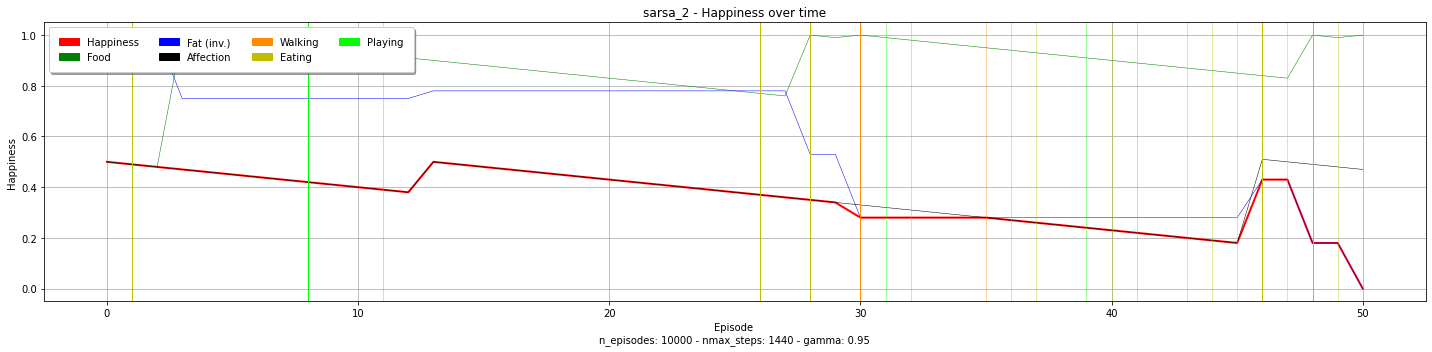

In [22]:
inv_action_dict = {v: k for k, v in action_dict.items()}

HAPPINESS_patch = mpatches.Patch(color=COLORS[0], label='Happiness')

WALKING_patch = mpatches.Patch(color=COLORS[inv_action_dict['WALKING']+3], label='Walking')
EATING_patch = mpatches.Patch(color=COLORS[inv_action_dict['EATING']+3], label='Eating')
PLAYING_patch = mpatches.Patch(color=COLORS[inv_action_dict['PLAYING']+3], label='Playing')

FOOD_patch = mpatches.Patch(color=COLORS[1], label='Food')
INV_FAT_patch = mpatches.Patch(color=COLORS[2], label='Fat (inv.)')
AFFECTION_patch = mpatches.Patch(color=COLORS[3], label='Affection')


fig = plt.figure(figsize=(20, 5))

y = evo_episode['happiness']
x = range(len(y))
plt.plot(x, y, label='happiness', color=COLORS[0], linewidth=2)

cnt=1
for i_characteristic in ['food', 'inv_fat', 'affection']:
    y = evo_episode[i_characteristic]
    x = range(len(y))
    plt.plot(x, y, label=i_characteristic, linewidth=0.5, color=COLORS[cnt])
    cnt += 1
            
for i in range(len(evo_episode['action'])):
    if evo_episode['action'][i] != 0:
        plt.axvline(x=i, color=COLORS[evo_episode['action'][i]+3], linewidth=0.75, alpha=0.5,
                    label=action_dict[evo_episode['action'][i]])
    if evo_episode['action_taken'][i] != 0:
        plt.axvline(x=i, color=COLORS[evo_episode['action_taken'][i]+3], linewidth=1, alpha=1,
                    label=action_dict[evo_episode['action_taken'][i]])

plt.title('{} - Happiness over time'.format(method))
plt.ylim([-0.05, 1.05])
plt.xlabel('Episode \n' + info_params)
plt.ylabel('Happiness')
plt.legend(handles=[HAPPINESS_patch, FOOD_patch, INV_FAT_patch, AFFECTION_patch,
                    WALKING_patch, EATING_patch, PLAYING_patch],
           loc="upper left", bbox_transform=fig.transFigure, ncol=4, fancybox=True, shadow=True, borderpad=1)
plt.grid(True)
plt.tight_layout()
#plt.savefig('data/figures/{}__episode_happiness.png'.format(method), format='png', dpi=500)
plt.show()
#plt.close(fig)

# Compare multiple episodes

In [53]:
list_methods = ['sarsa_1', 'sarsa_2']
evo_episode__happiness = {}

for method_id in list_methods:

    print(method_id)
    
    with open("models/{}__evo_episode.pkl".format(method_id), "rb") as input_file:
        evo_episode = dill.load(input_file)

    evo_episode__happiness[method_id] = evo_episode['happiness']


sarsa_1
sarsa_2


In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from src.utils.maths import get_avg_n_points
from src.utils.plots import COLORS

In [18]:
info_params_dict = {
    "n_episodes": 10000
    , "nmax_steps": 1440
    , "gamma": 0.95
}
info_params = get_info_params(info_params_dict)
info_params

'n_episodes: 10000 - nmax_steps: 1440 - gamma: 0.95'

In [59]:
fig = plt.figure()

cnt = 0
for method_id in list(evo_episode__happiness.keys()):

    y = evo_episode__happiness[method_id]
    x = range(len(y))

    plt.plot(
        x, y, label=method_id
        , marker='', color=COLORS[cnt], linewidth=1, alpha=0.75
    )
    cnt += 1

plt.title('Happiness over one episode')
plt.ylim([-0.05, 1.05])
plt.xlabel('Steps \n ' + info_params)
plt.ylabel('Happiness (smoothed)')
plt.legend(bbox_to_anchor=(0.5, -0.10), loc="lower center",
           bbox_transform=fig.transFigure, ncol=4, fancybox=True, shadow=True, borderpad=1)
plt.grid(True)
plt.tight_layout()
plt.savefig('data/figures/Comparison__episode.png', format='png', dpi=1000, bbox_inches='tight')
# plt.show()
plt.close(fig)

In [62]:
evo_episode['avg_reward']

0.038580645161290374

In [63]:
round(evo_episode['avg_reward'], 4)

0.0386